Подключаемые библиотеки

In [1]:
import re
import urllib2
import math
import numpy as np
import scipy.interpolate as ip
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import scipy.optimize as sco

from bs4 import BeautifulSoup

/usr/lib64/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Настройки отображения графиков:

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight') # The most fanciest styles are 'ggplot' and 'fivethirtyeight'
# All available styles may be checked by
#print plt.style.available

In [3]:
class sp_500():
    sector_tickers = {}
    
    def __init__(self):
        sector_tickers = dict()
        site = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        hdr = {'User-Agent': 'Mozilla/5.0'}
        req = urllib2.Request(site, headers=hdr)
        page = urllib2.urlopen(req)
        soup = BeautifulSoup(page)

        table = soup.find('table', {'class': 'wikitable sortable'})
    
        for row in table.findAll('tr'):
            col = row.findAll('td')
            if len(col) > 0:
                sector = str(col[3].string.strip()).lower().replace(' ', '_')
                ticker = str(col[0].string.strip())
                date = str(col[6]).replace('<td>', '').replace('</td>', '')
                #if date < historical_end_date:
                if sector not in self.sector_tickers:
                    self.sector_tickers[sector] = list()
                self.sector_tickers[sector].append(ticker)
    
    # Show sectors summary
    def sectors(self):
        for s in self.sector_tickers:
            print s + ': ' + str(len(self.sector_tickers[s])) + ' companies'
            
    # Show the sector summary and companies in it
    def show(self, sector = None):
        if sector == None:
            self.sectors()
        else:
            print sector + ' sector of S&P500\n' + str(len(self.sector_tickers[sector])) + ' companies:'
            print self.sector_tickers[sector]
    
    # Get the company symbols
    def get(self, sector = None):
        symbols = []
        if sector == None:
            # Get the companies from all S&P500 sectors
            for s in self.sector_tickers:
                print s + ': ' + str(len(self.sector_tickers[s])) + ' companies'
        else:
            # Get the companies from the given sector
            for sym in self.sector_tickers[sector]:
                symbols.append(sym)
        return symbols
            

In [4]:
class portfolio:
    data = []
    returns = []
    start_prices = []
    end_prices = []
    
    min_return = 0.0 # minimal return value 
    max_return = 0.7 # maximum return value
    step = 300 
    
    # Constructor
    def __init__(self, _symbols, _start, _end, _risk = None):
        # Initializing data
        self.data = pd.DataFrame()
        self.num_of_days = 0
        self.feasible_returns = []
        self.feasible_volatilities = []
        self.feasible_weights = []
    
        self.effective_volatilities = []
        self.effective_returns = []
        self.effective_weights = []
        
        self.symbols = []
        self.optimal_symbols = []
        self.days = []
        
        # 
        self.symbols = _symbols
        self.start = _start
        self.end = _end
        
        if _risk == None:
            self.max_risk = 0.25 # default risk value
        else:
            self.max_risk = _risk
        
        # 
        self.fetch()
        self.set_returns() 
        self.set_start_end_prices()
    
    #
    def set_days(self):
        for sym in self.symbols:
            self.days = []
            for i in range(0, self.num_of_days):
                self.days.append( str( re.split(' ', str(self.data[sym].axes[0][i]))[0]) )
                
            if len(self.days) == self.num_of_days:
                break
                
        if self.start != self.days[0] or self.end != self.days[-1]:
            self.start = self.days[0]
            self.end = self.days[-1]
            print 'Investment period adjusted to ' + self.start + ' - ' + self.end
    
    # Вычисление логарифмически нормализованых доходностей (отношения уровня закрытия текущего дня к предыдущему) за исторический период   
    def set_returns(self):
        self.returns = np.log(self.data / self.data.shift(1))
    
    # 
    def set_start_end_prices(self):
        self.start_prices = []
        self.end_prices = []
        for sym in self.symbols:
            self.start_prices.append(self.data[sym][self.start])
            self.end_prices.append(self.data[sym][self.end])
    
    # Retrieving data
    def fetch(self):
        fetched_symbols = []
        for sym in self.symbols:
            try:
                self.data[sym]  = web.DataReader(sym, data_source='yahoo', start=self.start, end=self.end)['Adj Close']
                fetched_symbols.append(sym)           
                if self.data[sym].size > self.num_of_days:
                    self.num_of_days = self.data[sym].size
            except IOError:
                print sym + ': no data available'
                continue
                
        self.data.column = fetched_symbols
    
        for sym in self.symbols:
            if sym not in fetched_symbols:
                self.symbols.remove(sym)
                
        self.set_days()
        print 'Data fetched for ' + str(len(self.symbols)) + ' symbols for '+ str(len(self.days)) + ' trading days'
    
    #
    def show(self, weights):
        print "Investment period: " + self.start + " - " + self.end
        print "Risk limit: " + str(self.max_risk)
        
        print "Portfolio volatility: " + str( self.statistics(weights)[0].round(3) )
        print "Portfolio return: " + str( self.statistics(weights)[1].round(3) )   
        print "Sharpe ratio: "  + str( self.statistics(weights)[2].round(3) )  
        print ""
            
        for sym, w in zip(self.optimal_symbols, self.optimal_weights):
            print sym + ': ' + str(w)
    
    #
    def calc(self):
        self.get_effective_set()
        self.show( self.get_max_sharpe_portfolio() )
    
    # 
    def get(self):
        if len(self.optimal_symbols) > 0:
            return self.optimal_symbols, self.optimal_weights
        else:
            print 'The optimal portfolio is not calculated. Run calc() first'
    
    # Вычисление эффективного множества (effective set)
    def get_effective_set(self):
        self.effective_volatilities = []
        self.effective_returns = []
        self.effective_weights = []
    
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds = tuple((0, 1) for x in range(len(self.symbols)))

        for y in np.linspace(self.min_return, self.max_return, self.step):
            cons = ({'type': 'eq', 'fun': lambda x: self.statistics(x)[1] - y}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            result = sco.minimize(self.min_volatility, len(self.symbols) * [1. / len(self.symbols),], method='SLSQP', bounds=bnds, constraints=cons)
            if result['fun'] <= self.max_risk:
                self.effective_volatilities.append(result['fun'])
                self.effective_returns.append(y)
                self.effective_weights.append(result['x'])
    
        self.effective_volatilities = np.array(self.effective_volatilities)
        self.effective_returns = np.array(self.effective_returns)
        self.effective_weights = np.array(self.effective_weights)

    # Функция, получающая веса бумаг в портфеле в качестве входных параметров, и возвращающая массив 
    # данных о портфеле в формате [волатильность, доходность, коэффициент Шарпа]
    def statistics(self, weights):
        weights = np.array(weights)
        portfolio_return = self.get_portfolio_return(weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() * self.num_of_days, weights)))
    
        return np.array([portfolio_volatility, portfolio_return, portfolio_return / portfolio_volatility])
    
    # Функция вычисления минимального отклонения
    def min_volatility(self, weights):
        return self.statistics(weights)[0]
    
    # Функция вычисления доходности портфеля
    def get_portfolio_return(self, weights):
        portfolio_start_price = 0
        portfolio_end_price = 0

        for w, sp, ep in zip(weights, self.start_prices, self.end_prices):
            portfolio_start_price = portfolio_start_price + w * sp
            portfolio_end_price = portfolio_end_price + w * ep
            
        return ((portfolio_end_price - portfolio_start_price) / portfolio_start_price)
        #return np.sum(returns.mean() * weights) * num_of_days
    
    # Функция вычисления портфеля с максимальным коэффицентом Шарпа (отношением доходность/волатильность)
    def get_max_sharpe_portfolio(self):
        max_sharpe = 0
        weights = []
        for r, v, w in zip(self.effective_returns, self.effective_volatilities, self.effective_weights):
            if r / v > max_sharpe:
                max_sharpe =  r / v
                weights = w
                
        self.optimal_symbols = []
        self.optimal_weights = []
        for sym, w in zip(self.symbols, weights):
            if w.round(3) > 0.001:
                self.optimal_symbols.append(sym)
                self.optimal_weights.append(w.round(3)) # FIXME: shoudn't round value maybe
        
        return weights
    
    #
    def get_min_variance_portfolio(self):
        min_variace = 10
        min_variance_portfolio = []
        for v, w in zip(self.effective_volatilities, self.effective_weights):
            if v < min_variace:
                min_variace =  v
                min_variance_portfolio = w

        return min_variance_portfolio
    
    def plot(self):
        plt.figure(figsize=(12, 6))

        x_sharpe = self.statistics(self.get_max_sharpe_portfolio())[0]
        y_sharpe = self.statistics(self.get_max_sharpe_portfolio())[1]

        x_min_vol = self.statistics(self.get_min_variance_portfolio())[0]
        y_min_vol = self.statistics(self.get_min_variance_portfolio())[1]

        #plt.scatter(feasible_volatilities, feasible_returns, c = feasible_returns / feasible_volatilities, marker='o')
        plt.scatter(self.effective_volatilities, self.effective_returns, c = self.effective_returns / self.effective_volatilities, marker='x')
        plt.plot(x_sharpe, y_sharpe, 'rs', markersize=8.0) # portfolio with highest Sharpe ratio
        plt.plot(x_min_vol, y_min_vol, 'ys', markersize=8.0) # portfolio with highest Sharpe ratio

        plt.colorbar(label='Sharpe ratio')
        plt.xlabel(r'$\sigma_p$')
        plt.ylabel(r'$\bar{r_p}$')
        

Получение наименования компаний, входящих в S&P500 на данный момент (в момент запуска) 

In [5]:
sp500 = sp_500()

/usr/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [6]:
sp500.sectors()

industrials: 67 companies
energy: 41 companies
consumer_discretionary: 85 companies
utilities: 29 companies
telecommunications_services: 5 companies
materials: 27 companies
health_care: 56 companies
consumer_staples: 38 companies
financials: 89 companies
information_technology: 67 companies


In [7]:
sp500.show('energy')

energy sector of S&P500
41 companies:
['APC', 'APA', 'BHI', 'COG', 'CAM', 'CHK', 'CVX', 'XEC', 'CPGX', 'CXO', 'COP', 'CNX', 'DVN', 'DO', 'ESV', 'EOG', 'EQT', 'XOM', 'FTI', 'HAL', 'HP', 'HES', 'KMI', 'MRO', 'MPC', 'MUR', 'NOV', 'NFX', 'NBL', 'OXY', 'OKE', 'PSX', 'PXD', 'RRC', 'SLB', 'SWN', 'SE', 'TSO', 'RIG', 'VLO', 'WMB']


In [8]:
max_risk = 0.3
p = portfolio(sp500.get('telecommunications_services'), '2014-01-01', '2015-01-01', max_risk)

Investment period adjusted to 2014-01-02 - 2014-12-31
Data fetched for 5 symbols for 252 trading days


Вычисление оптимального портфеля

In [9]:
p.calc()

Investment period: 2014-01-02 - 2014-12-31
Risk limit: 0.3
Portfolio volatility: 0.183
Portfolio return: 0.389
Sharpe ratio: 2.13

CTL: 0.597
FTR: 0.118
LVLT: 0.284


In [10]:
p.get()

(['CTL', 'FTR', 'LVLT'],
 [0.59699999999999998, 0.11799999999999999, 0.28399999999999997])

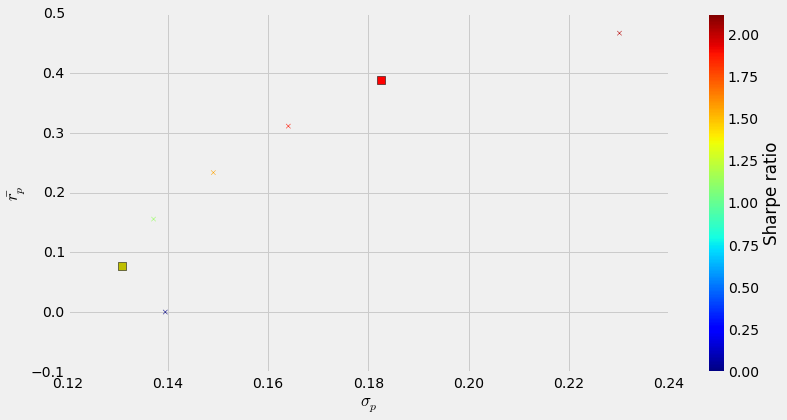

In [11]:
p.plot()

Создаём еще один портфель (на основе полученного оптимального портфеля) и проверяем его доходность на нужном промежутке времени

In [48]:
#t = portfolio()

TODO: portfolio.plot() method

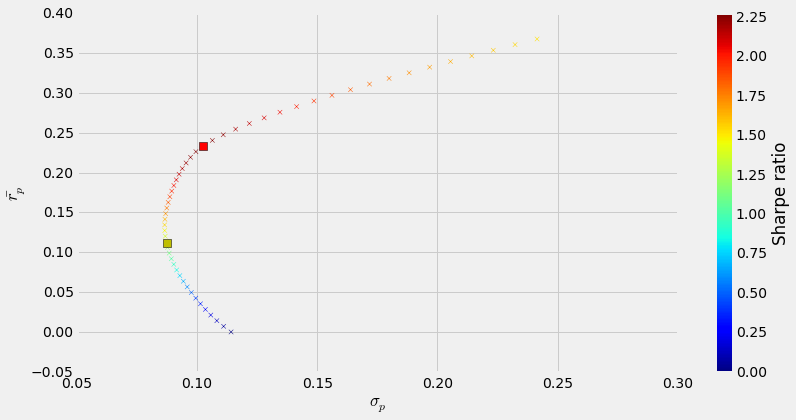

In [156]:
plt.figure(figsize=(12, 6))

x_sharpe = statistics(optimal_sharpe)[0]
y_sharpe = statistics(optimal_sharpe)[1]

x_min_vol = statistics(minimal_volatility)[0]
y_min_vol = statistics(minimal_volatility)[1]

#plt.scatter(feasible_volatilities, feasible_returns, c = feasible_returns / feasible_volatilities, marker='o')
plt.scatter(effective_volatilities, effective_returns, c = effective_returns / effective_volatilities, marker='x')
plt.plot(x_sharpe, y_sharpe, 'rs', markersize=8.0) # portfolio with highest Sharpe ratio
plt.plot(x_min_vol, y_min_vol, 'ys', markersize=8.0) # portfolio with highest Sharpe ratio

plt.colorbar(label='Sharpe ratio')
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\bar{r_p}$')
